In [1]:
import pandas as pd
import numpy as np
from readFile import split_into_values, toRPdata
# columns 와 value는 사용자 입력
# df = pd.read_csv('resources/AXISX_resample.csv')
df = pd.read_csv('resources/CLAMP_resample.csv')
columns = ['chip', 'wire', 'segment']
value = ['value']
#df = pd.read_csv('resources/Dataset1.csv')
#columns = ['Process', 'Step']
#value = ['Value']

df = df.loc[:, columns + value] #('chip', 'wire', 'value')는 사용자 입력
size = 28
result = split_into_values(df, columns)

# dataframe -> list
result_list = result.values.tolist()

from sklearn.preprocessing import MinMaxScaler

def MinMax(data):
    MMS = MinMaxScaler().fit(data)
    scaled = MMS.transform(data)
    return scaled

# result_list transpose
result_T = [list(x) for x in zip(*result_list)]

# minmax 정규화
result_scaled = MinMax(result_T)

# 다시 result transpose 해서 원래대로
result_scaled = [list(x) for x in zip(*result_scaled)]

from tslearn.preprocessing import TimeSeriesScalerMeanVariance, TimeSeriesResampler

# 2. 시계열 셋 크기 변경
result_ = TimeSeriesResampler(sz=size).fit_transform(result_scaled)

In [10]:
# 2. 시계열 셋 크기 변경
result_ = TimeSeriesResampler(sz=size).fit_transform(result_scaled)

result_.shape

(1140, 28, 1)

In [2]:
data = result_.reshape(result_.shape[0], 1, size)
X = toRPdata(data, threshold='point', percentage=30)
#X = toRPdata(data)
    
X_scaled = np.expand_dims(X, axis=3)
X_scaled.shape

(1140, 28, 28, 1)

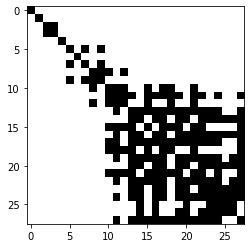

In [12]:
from matplotlib import pyplot as plt
plt.imshow(X[0], cmap='Greys')

In [3]:
#you will use a batch size of 128 using a higher batch size of 256 or 512 is also preferable
batch_size = 128
learning_rate = 0.0001
epochs = 5
optimizer='Adam'
loss='mse'

In [4]:
from utils import split_data, normalization_tool
from agent import Autoencoder_Agent
from utils import optimizer_set
from keras.models import Sequential
from keras.layers import Dropout, Activation, Dense
from keras.layers.convolutional import Conv2D, MaxPooling2D, UpSampling2D

#lr 바뀔때는 실행하지 말것! 새로운 rp 적용할때는 한번 적용!
X_train, X_test, Y_train, Y_test = split_data(X_scaled, X_scaled) #데이터 분리

optimizer = optimizer_set(optimizer, learning_rate)
model = Sequential()
 
#1st convolution layer
model.add(Conv2D(16, (3, 3) #16 is number of filters and (3, 3) is the size of the filter.
, padding='same', input_shape=(28,28,1)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2), padding='same'))

#2nd convolution layer
model.add(Conv2D(2,(3, 3), padding='same')) # apply 2 filters sized of (3x3)
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2), padding='same'))

#here compressed version

#3rd convolution layer
model.add(Conv2D(2,(3, 3), padding='same')) # apply 2 filters sized of (3x3)
model.add(Activation('relu'))
model.add(UpSampling2D((2, 2)))

#4rd convolution layer
model.add(Conv2D(16,(3, 3), padding='same'))
model.add(Activation('relu'))
model.add(UpSampling2D((2, 2)))

model.add(Conv2D(1,(3, 3), padding='same'))
model.add(Activation('sigmoid'))
model.summary()


model.compile(optimizer=optimizer, loss=loss) #사용자 지정 파라미터(optimizer, loss)

c:\users\shims\anaconda3\envs\foodflask\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 16)        160       
_________________________________________________________________
activation (Activation)      (None, 28, 28, 16)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 2)         290       
_________________________________________________________________
activation_1 (Activation)    (None, 14, 14, 2)         0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 2)           0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 2)           3

In [5]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=100, min_delta=0.0001)
mc = ModelCheckpoint(f'CLAMP28_0.001_Autoencoder_weight.h5', monitor='val_loss', verbose=1, save_best_only=True)

In [6]:
new_hist = model.fit(X_train, X_train,
          batch_size = batch_size,epochs=epochs,
          validation_data=(X_test,X_test),callbacks=[es, mc]
         )

Epoch 1/5
7/7 [==============================] - ETA: 0s - loss: 0.2500
Epoch 00001: val_loss improved from inf to 0.24984, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 0s 67ms/step - loss: 0.2500 - val_loss: 0.2498
Epoch 2/5
1/7 [===>..........................] - ETA: 0s - loss: 0.2499
Epoch 00002: val_loss improved from 0.24984 to 0.24957, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 0s 11ms/step - loss: 0.2497 - val_loss: 0.2496
Epoch 3/5
1/7 [===>..........................] - ETA: 0s - loss: 0.2496
Epoch 00003: val_loss improved from 0.24957 to 0.24928, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 0s 11ms/step - loss: 0.2495 - val_loss: 0.2493
Epoch 4/5
1/7 [===>..........................] - ETA: 0s - loss: 0.2493
Epoch 00004: val_loss improved from 0.24928 to 0.24897, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [=====================

In [22]:
import pickle

hist = {}
try: 
    prev_hist = pickle.load(open(f'28_Autoencoder_{batch_size}_{learning_rate}history', "rb"))
except:
    hist = new_hist.history
else:
    for key in prev_hist.keys():
        hist[key] = prev_hist[key] + new_hist.history[key]
hist

{'loss': [0.2502574622631073,
  0.24986422061920166,
  0.24950721859931946,
  0.24916906654834747,
  0.24883393943309784,
  0.24849548935890198,
  0.24815091490745544,
  0.24780037999153137,
  0.2474425584077835,
  0.24707652628421783,
  0.2467029094696045,
  0.24632121622562408,
  0.24593159556388855,
  0.24553349614143372,
  0.24512630701065063,
  0.2447073608636856,
  0.24427802860736847,
  0.24383710324764252,
  0.24338458478450775,
  0.2429199367761612,
  0.2424434870481491,
  0.24195513129234314,
  0.2414565235376358,
  0.24094611406326294,
  0.24042481184005737,
  0.23989304900169373,
  0.23934876918792725,
  0.23879219591617584,
  0.23821978271007538,
  0.23763492703437805,
  0.23703525960445404,
  0.236420139670372,
  0.23578566312789917,
  0.2351176142692566,
  0.23441313207149506,
  0.2336706668138504,
  0.23289260268211365,
  0.23201578855514526,
  0.23083935678005219,
  0.22895650565624237,
  0.22647976875305176,
  0.2242305427789688,
  0.22247609496116638,
  0.22093811631

In [23]:
with open(f'28_Autoencoder_{batch_size}_{learning_rate}history', 'wb') as file_pi:
        pickle.dump(hist, file_pi)

In [ ]:
for key in hist.keys():
    hist[key] = hist[key][-3624:]

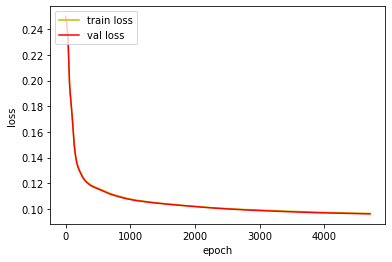

In [24]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

loss_ax.plot(hist['loss'], 'y', label='train loss')
loss_ax.plot(hist['val_loss'], 'r', label='val loss')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')


loss_ax.legend(loc='upper left')


plt.show()

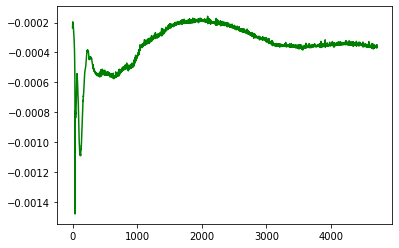

In [25]:
plt.plot([hist['val_loss'][i] - hist['loss'][i] for i in range(len(hist['loss']))], 'g', label='loss - val loss')
plt.show()

In [ ]:
y_pred = model.predict(X_test)
# print(y_pred[0])
# print(X_test.shape)
# print(((np.round(y_pred[0]) == X_test[0]) + (np.round(y_pred[1]) == X_test[1]))/ 2)
l = len(X_test)
acc = sum([np.round(y_pred[i])==X_test[i] for i in range(l)])/l
# acc = sum([y_pred[i]==X_test[i] for i in range(l)])/l
np.mean(acc)

In [84]:
model.save_weights(f'28_Autoencoder_{batch_size}_{learning_rate}_weight.h5')